In [1]:
# pip install faiss-gpu-cu12

In [2]:
# pip install langchain-text-splitters

In [3]:
# pip install langchain-huggingface sentence-transformers

In [4]:
# pip install langchain-community

In [5]:
# pip install pypdf

In [6]:
# pip install jq

In [ ]:
import os
import json
import pandas as pd
import random
import pickle

from typing import List, Optional, Dict

import faiss
import numpy as np
from tqdm import tqdm
from langchain_community.document_loaders import (
    PyPDFLoader,
    TextLoader,
    JSONLoader
)
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from matplotlib import pyplot as plt
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM

import torch
from torch import Tensor
import torch.nn.functional as F

/home/russele7/practicum/dle/practicum_dle_sprint_7/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# pip install matplotlib

In [9]:
# from google.colab import drive
# drive.mount('/content/drive')

In [10]:
# main_path = '/content/drive/MyDrive/PRACTICUM_DLE/sprint_7/'
main_path = ''

# 1 EDA

In [11]:
data_path = main_path + 'nlp_s3_project/'

data_json_path = data_path + 'arxiv-metadata-s.json'
data_csv_path = data_path + 'test_sample.csv'

data_sample_path = data_path + 'sample_data.json'
data_sample2_path = data_path + 'sample_data2.json'
data_sample3_path = data_path + 'sample_data3.json'
data_sample4_path = data_path + 'sample_data4.json'


data_partial_path = main_path + 'partial_data/'

data_partial_file1_path = data_partial_path + '1.json'

In [12]:
# with open(data_path + 'sample_data.json', 'w') as file:
#   json.dump(train_data[:10000], file)

In [13]:
with open(data_json_path, 'r') as file:
  train_data = json.load(file)

In [14]:
len(train_data)

98213

In [15]:
# step = 10_000
# for i in tqdm(range(len(train_data)// step + 1)):
#     # print(i, step * i , step * (i + 1))

#     sample_step_data = train_data[step * i : step * (i + 1)]

#     with open(data_partial_path + f'{i}.json', 'w') as file:
#         json.dump(sample_step_data, file)

In [16]:
with open(data_sample_path, 'r') as file:
  sample_data = json.load(file)

In [17]:
len(sample_data)

1000

In [18]:
# with open(data_sample2_path, 'r') as file:
#   sample_data2 = json.load(file)

In [19]:
# with open(data_sample3_path, 'r') as file:
#   sample_data3 = json.load(file)

In [20]:
# with open(data_sample4_path, 'r') as file:
#   sample_data4 = json.load(file)

In [21]:
# len(sample_data), len(sample_data2), len(sample_data3), len(sample_data4), 

In [22]:
df_test = pd.read_csv(data_csv_path)

In [23]:
df_test.shape

(1000, 3)

In [24]:
# print(df_test[:100]['id'].tolist())

In [25]:
# our_ids = []
# for i, elem in tqdm(enumerate(train_data)):
#     if elem['id'] in df_test[:100]['id'].tolist():
#         # print(i)
#         our_ids.append(i)

In [26]:
# our_ids = []
# for j, row in tqdm(df_test[:100].iterrows()):
#     for i, elem in (enumerate(train_data)):
#         if elem['id'] == row['id']:
#             our_ids.append(i)

In [27]:
# sample_data4 = [train_data[i] for i in our_ids] #+ random.sample(train_data, 100)
# len(sample_data4)

In [28]:
# sample_data4[0]

In [29]:
# with open(data_path + 'sample_data4.json', 'w') as file:
#   json.dump(sample_data4, file)

In [30]:
df_test.head()

,id,abstract,query
0,2412.16732,A new platinate was recently discovered when...,What unique composition and decomposition beha...
1,nucl-th/9602019,The production cross sections of various fra...,How does the inclusion of statistical decay af...
2,2501.05500,This survey provides a comprehensive examina...,What are the core components of modern zero-kn...
3,2506.20892,A critical challenge for operating fusion burn...,How does impurity seeding affect the timing an...
4,2208.02031,"In this work, we present the first corpus fo...",What is the primary challenge of the newly dev...


## 1.1 Train data

In [31]:
# df_train = pd.DataFrame(random.sample(train_data, 10000))
df_train = pd.DataFrame(train_data)

In [32]:
df_train.head(3)

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
0,0704.0038,Maxim A. Yurkin,"Maxim A. Yurkin, Alfons G. Hoekstra",The discrete dipole approximation: an overview...,"36 pages, 1 figure; added several corrections ...","J.Quant.Spectrosc.Radiat.Transf. 106, 558-589 ...",10.1016/j.jqsrt.2007.01.034 10.1016/j.jqsrt.20...,None,physics.optics physics.comp-ph,http://creativecommons.org/licenses/by-nc-nd/4.0/,We present a review of the discrete dipole a...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2022-03-30,"[[Yurkin, Maxim A., ], [Hoekstra, Alfons G., ]]"
1,0704.0057,Philipp Werner,Philipp Werner and Andrew J. Millis,High-spin to low-spin and orbital polarization...,Published version,"Phys. Rev. Lett. 99, 126405 (2007)",10.1103/PhysRevLett.99.126405,None,cond-mat.str-el,None,We study the interplay of crystal field spli...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2009-11-13,"[[Werner, Philipp, ], [Millis, Andrew J., ]]"
2,0704.0060,Carlos Bertulani,"C.A. Bertulani, G. Cardella, M. De Napoli, G. ...",Coulomb excitation of unstable nuclei at inter...,"12 pages, 2 figures, accepted for publication ...","Phys.Lett.B650:233-238,2007",10.1016/j.physletb.2007.05.029,None,nucl-th,None,We investigate the Coulomb excitation of low...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2008-11-26,"[[Bertulani, C. A., ], [Cardella, G., ], [De N..."


## title

<Axes: >

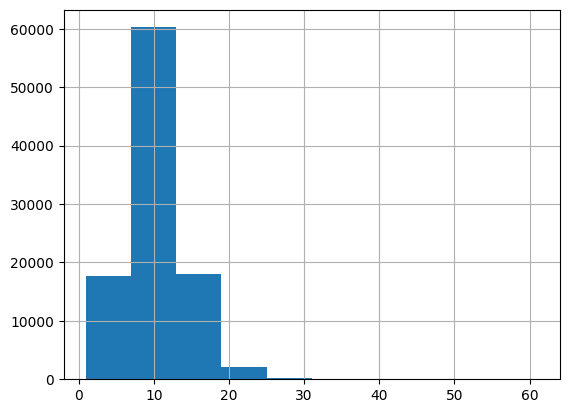

In [33]:
df_train['title'].apply(lambda x: len(x.split())).hist()

<Axes: >

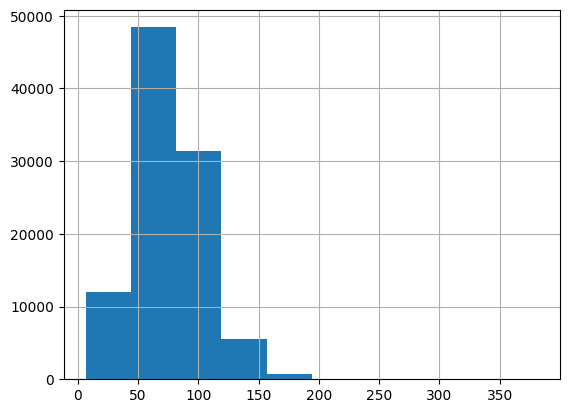

In [34]:
df_train['title'].str.len().hist()

<Axes: >

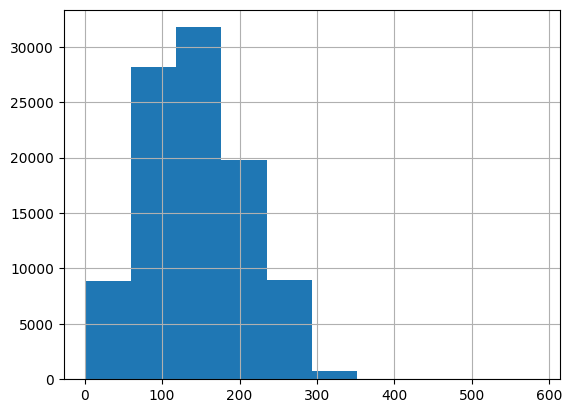

In [35]:
df_train['abstract'].apply(lambda x: len(x.split())).hist()

<Axes: >

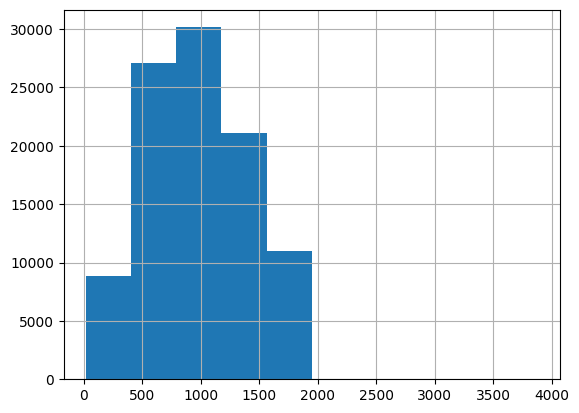

In [36]:
df_train['abstract'].str.len().hist()

# Длины эмбеддингов

In [37]:
embedder_name = "intfloat/e5-base-v2"

device = "cuda" if torch.cuda.is_available() else "cpu"
emb_tokenizer = AutoTokenizer.from_pretrained(embedder_name)

In [38]:
check_tokens = emb_tokenizer(df_train['abstract'].sample(5000).tolist())

Token indices sequence length is longer than the specified maximum sequence length for this model (732 > 512). Running this sequence through the model will result in indexing errors


In [39]:
# rezu.keys()

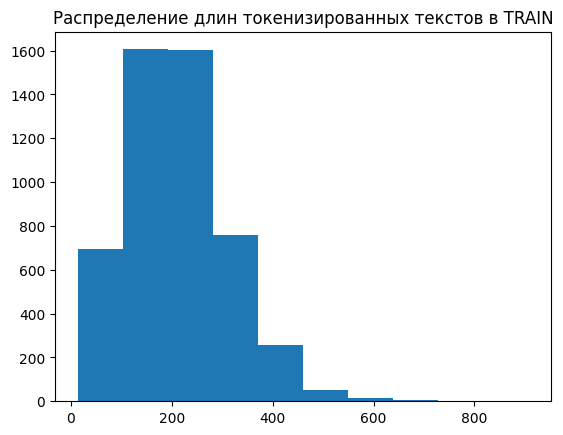

In [40]:
plt.hist([len(tk) for tk in check_tokens['input_ids']])
plt.title('Распределение длин токенизированных текстов в TRAIN');

## submitter

In [41]:
df_train['submitter'].value_counts()

submitter
EPTCS                      140
The CMS Collaboration       45
The ATLAS Collaboration     21
Yang Li                     20
Yang Liu                    19
                          ... 
Arnab Patra                  1
Michael Schlosser            1
Aleksandar Vakanski          1
Xiyang Dai                   1
Zhaoyang Lv                  1
Name: count, Length: 76466, dtype: int64

## tags

### tags - уникальные

In [42]:
categories_dict = {}
for cats in df_train['categories']:
  for cat in cats.split():
    if cat in categories_dict:
      categories_dict[cat] += 1
    else:
      categories_dict[cat] = 1

In [43]:
df_cats = pd.DataFrame([[k, v] for k, v in categories_dict.items()], columns=['category', 'count']).sort_values('count', ascending=False).reset_index(drop=True)
df_cats

,category,count
0,cs.LG,8152
1,hep-ph,6692
2,hep-th,6111
3,quant-ph,5783
4,cs.CV,5668
...,...,...
169,atom-ph,6
170,supr-con,6
171,chem-ph,5
172,mtrl-th,5


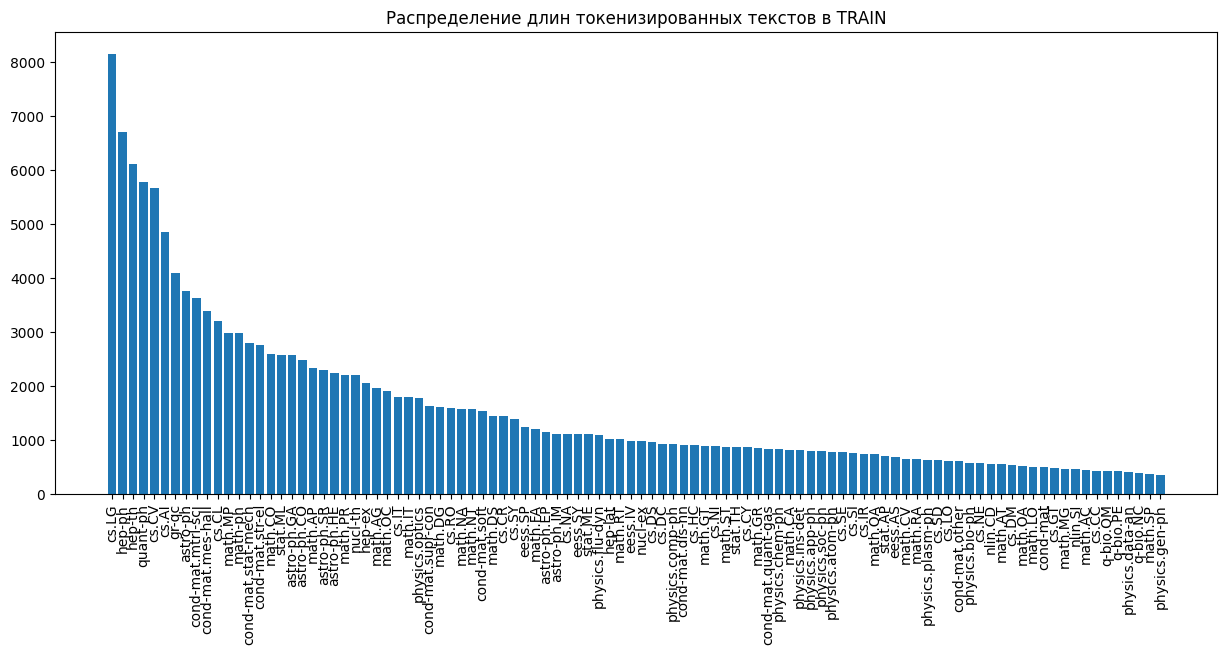

In [44]:
plt.figure(figsize=(15, 6))
plt.bar(x=df_cats[:100]['category'], height=df_cats[:100]['count'])
plt.xticks(rotation=90)
plt.title('Распределение длин токенизированных текстов в TRAIN');

### tags - комбинированные

In [45]:
categories_multi_dict = {}
for cats in df_train['categories']:
  if cats in categories_multi_dict:
    categories_multi_dict[cats] += 1
  else:
    categories_multi_dict[cats] = 1

In [46]:
df_multi_cats = pd.DataFrame(
    [[k, v] for k, v in categories_multi_dict.items()], 
    columns=['category', 'count']
).sort_values('count', ascending=False).reset_index(drop=True)
df_multi_cats

,category,count
0,astro-ph,3103
1,hep-ph,2981
2,quant-ph,2595
3,cs.CV,2556
4,hep-th,2118
...,...,...
11059,quant-ph cond-mat hep-th supr-con,1
11060,quant-ph chao-dyn hep-th nlin.CD,1
11061,quant-ph dg-ga hep-th math.DG,1
11062,quant-ph comp-gas hep-lat hep-th nlin.CG,1


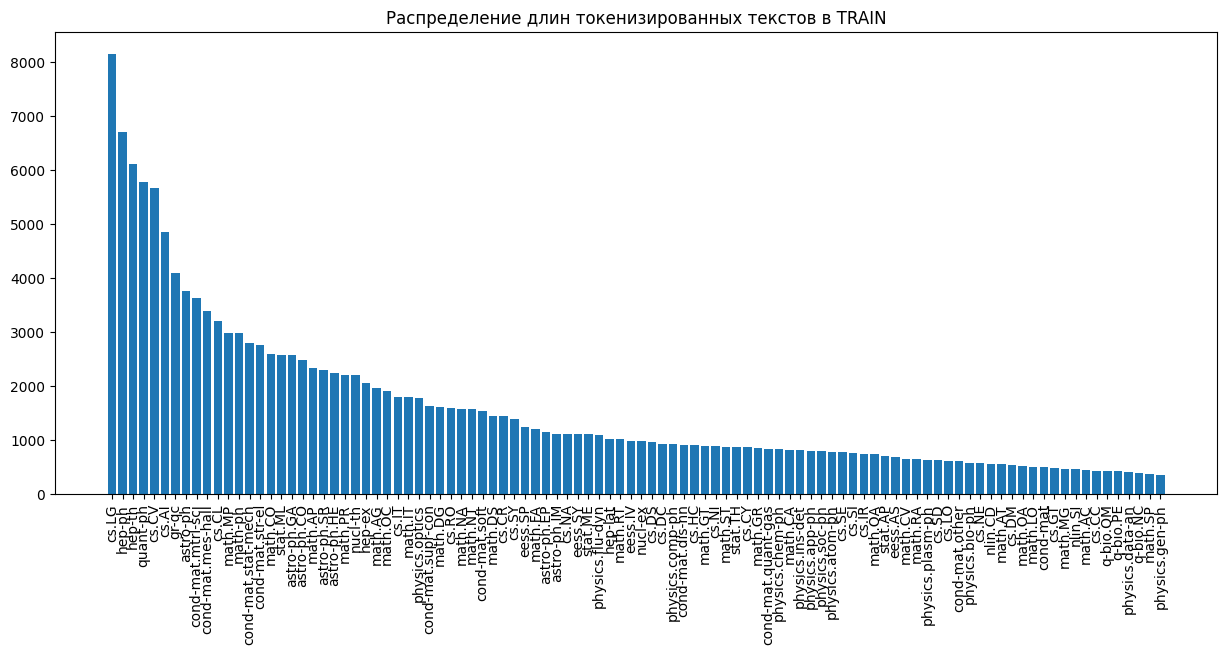

In [47]:
plt.figure(figsize=(15, 6))
plt.bar(x=df_cats[:100]['category'], height=df_cats[:100]['count'])
plt.xticks(rotation=90)
plt.title('Распределение длин токенизированных текстов в TRAIN');

In [48]:
df_train['categories'].apply(lambda x: len(x.split())).value_counts().reset_index()

,categories,count
0,1,51443
1,2,29521
2,3,11987
3,4,3847
4,5,1117
5,6,248
6,7,41
7,8,4
8,9,3
9,10,2


## update_date

<Axes: >

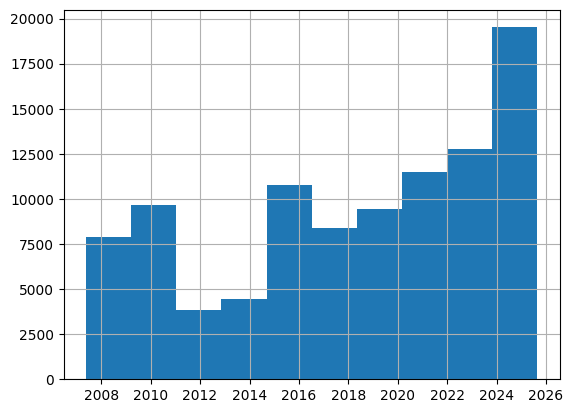

In [49]:
pd.to_datetime(df_train['update_date']).hist()

## versions

In [50]:
df_train['versions'].apply(lambda x: len(x)).value_counts()

versions
1     59423
2     26245
3      8558
4      2599
5       810
6       300
7       114
8        73
9        23
10       20
11       11
14        8
13        6
12        6
15        3
67        2
18        2
22        2
16        2
25        1
17        1
24        1
21        1
19        1
42        1
Name: count, dtype: int64

## authors_parsed

In [51]:
df_train.head(2)

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
0,0704.0038,Maxim A. Yurkin,"Maxim A. Yurkin, Alfons G. Hoekstra",The discrete dipole approximation: an overview...,"36 pages, 1 figure; added several corrections ...","J.Quant.Spectrosc.Radiat.Transf. 106, 558-589 ...",10.1016/j.jqsrt.2007.01.034 10.1016/j.jqsrt.20...,None,physics.optics physics.comp-ph,http://creativecommons.org/licenses/by-nc-nd/4.0/,We present a review of the discrete dipole a...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2022-03-30,"[[Yurkin, Maxim A., ], [Hoekstra, Alfons G., ]]"
1,0704.0057,Philipp Werner,Philipp Werner and Andrew J. Millis,High-spin to low-spin and orbital polarization...,Published version,"Phys. Rev. Lett. 99, 126405 (2007)",10.1103/PhysRevLett.99.126405,None,cond-mat.str-el,None,We study the interplay of crystal field spli...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2009-11-13,"[[Werner, Philipp, ], [Millis, Andrew J., ]]"


In [52]:
df_train['authors_parsed'].apply(lambda x: len(x)).value_counts().reset_index()

,authors_parsed,count
0,2,23765
1,3,20062
2,1,18289
3,4,12920
4,5,7522
...,...,...
271,621,1
272,109,1
273,220,1
274,1085,1


## 1.2 Test data

In [53]:
df_test.head()

,id,abstract,query
0,2412.16732,A new platinate was recently discovered when...,What unique composition and decomposition beha...
1,nucl-th/9602019,The production cross sections of various fra...,How does the inclusion of statistical decay af...
2,2501.05500,This survey provides a comprehensive examina...,What are the core components of modern zero-kn...
3,2506.20892,A critical challenge for operating fusion burn...,How does impurity seeding affect the timing an...
4,2208.02031,"In this work, we present the first corpus fo...",What is the primary challenge of the newly dev...


In [54]:
df_test.loc[0, 'query']

'What unique composition and decomposition behavior does the newly discovered platinate Nd10.67Pt4O24 exhibit under thermal conditions?'

In [55]:
df_test.loc[0, 'abstract']

"  A new platinate was recently discovered when Nd2O3 was explored as a platinum\ncapture material in the Ostwald process, formed by a direct reaction between\nPtO2(g) and Nd2O3. The crystal structure of this new platinate and its\ncomposition, Nd10.67Pt4O24 , are here reported for the first time. The compound\nis synthesized either by a direct reaction using PtO2(g) or by the citric acid\nchemical route. Based on 3-dimensional electron diffraction data and Rietveld\nrefinement of high-resolution synchrotron and neutron powder diffraction data,\nwe accurately describe its crystal structure in space group I41/a. The compound\nis structurally related to the Ln11-xSrxIr4O24 (Ln = La, Pr, Nd, Sm) phases\nwith a double-perovskite (A2BB'O6) like crystal structure and A-site\ncation-deficiency. Owing to the fixed oxidation state of Pt(IV), two of the\nfour Nd-sites are partly occupied to provide charge neutrality, with the Nd4\nsite taking a split position. On heating, Nd10.67Pt4O24 decompose

<Axes: >

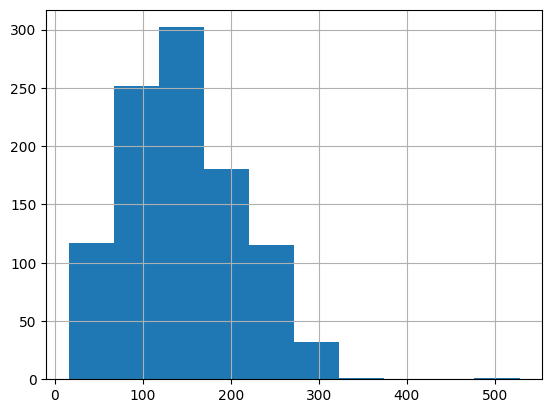

In [56]:
df_test['abstract'].apply(lambda x: len(x.split())).hist()

<Axes: >

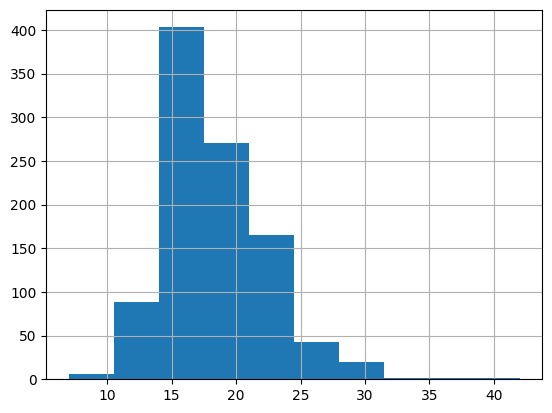

In [57]:
df_test['query'].apply(lambda x: len(x.split())).hist()

# Выводы по EDA

1. как вы будете решать задачу;
- Сделаем RAG+LLM
2. какие подходы к поиску примените и почему;
- Графовая БД index какой-то
3. какие модели выберете и от каких ограничений будете отталкиваться;
- Как в примерах
4. из чего будет состоять ваша система.
- Загрузчик данных
- Ембеддер данных
- БДшка векторная и индекс
- функция поиска релевантных данных к запросу
- функция ранжирования релеввантных
- Формирование комби запроса с учетом релевантных
- Инференс с ЛЛМ
- расчет метрики

# 2 Этап 2. Реализация retrieval-системы

## 2.1 Обучим свой индекс

### 2.1.1 Генерим эмбеддинги

In [86]:
class EMBEDDER:

    def __init__(
        self,
        embedder_name: str = "intfloat/e5-base-v2",
        device: Optional[str] = None,
    ):
        self.device = device or ("cuda"
                                 if torch.cuda.is_available() else "cpu")
        self.emb_tokenizer = AutoTokenizer.from_pretrained(embedder_name)
        self.embedder = AutoModel.from_pretrained(embedder_name).to(
            self.device)
        self.embedder.eval()
        # self.max_length = 8192
        self.max_length = 512

    def _generate_embeddings(self, texts: List[str]) -> np.ndarray:
        inputs = self.emb_tokenizer(
            texts,
            padding='max_length',
            truncation=True,
            return_tensors="pt",
            max_length=self.max_length,
        ).to(self.device)

        with torch.no_grad():
            outputs = self.embedder(**inputs)

        inputs.to("cpu")
        embeddings = self.last_token_pool(outputs.last_hidden_state,
                                          inputs.attention_mask).cpu()
        return F.normalize(embeddings, p=2, dim=1).numpy()

    @staticmethod
    def last_token_pool(last_hidden_states: Tensor,
                        attention_mask: Tensor) -> Tensor:
        left_padding = (attention_mask[:, -1].sum() == attention_mask.shape[0])
        if left_padding:
            return last_hidden_states[:, -1]
        else:
            sequence_lengths = attention_mask.sum(dim=1) - 1
            batch_size = last_hidden_states.shape[0]
            return last_hidden_states[
                torch.arange(batch_size, device=last_hidden_states.device),
                sequence_lengths]

    # Define the metadata extraction function.

    def make_embeddings(self, texts: List[str], batch_size: int = 4) -> None:

        # Вычислим numpy-эмбеддинги по батчам
        embeddings = []
        for i in tqdm(range(0, len(texts), batch_size)):
            batch = texts[i:i + batch_size]
            embeddings.append(self._generate_embeddings(batch))

        # embeddings = np.concatenate(embeddings)

        # Инициализируем индекс
        return embeddings

In [87]:
embedder = EMBEDDER()

In [88]:
batch_size = 1024

In [89]:
for i in tqdm(range(len(df_train) // batch_size + 1)):
    # print(i, i*batch_size, (i+1) * batch_size)
    batch = df_train[i*batch_size:(i+1) * batch_size]['abstract'].tolist()
    text_embeddings = embedder.make_embeddings(batch, batch_size=4)
    conc_embs = np.concatenate(text_embeddings)
    
    with open(main_path + f'embeddings/{i}_{i*batch_size}_{(i+1) * batch_size}.pkl', 'wb') as file_out:
        pickle.dump(conc_embs, file_out)

100%|██████████| 96/96 [44:02<00:00, 27.53s/it]


In [70]:
np.concatenate(text_embeddings).shape

(64, 768)

In [64]:
len(df_train)

98213

In [ ]:
# train_texts = df_train.sample(4000)['abstract'].tolist()

In [ ]:
# text_embeddings = embedder.make_embeddings(train_texts, batch_size=4)

In [ ]:
# text_embeddings = np.concatenate(text_embeddings)

In [ ]:
# text_embeddings.shape

### 2.1.2 Задаем индекс

In [ ]:
# d = text_embeddings.shape[1]
# d

In [ ]:
# nlist = 100
# quantizer = faiss.IndexFlatL2(d) # где d, размерность векторов, была задана ранее
# index = faiss.IndexIVFFlat(quantizer, d, nlist)
# assert not index.is_trained # в начале индекс "не обучен"
# index.train(text_embeddings)             # обучаем индекс
# assert index.is_trained
# index.add(text_embeddings)  

In [ ]:
# assert not index.is_trained # в начале индекс "не обучен"
# index.train(text_embeddings)             # обучаем индекс
# assert index.is_trained

In [ ]:
# index.add(text_embeddings)  

In [ ]:
# D, I = index.search(
#     np.concatenate(embedder.make_embeddings(df_train.sample(8)['abstract'].tolist(), batch_size=4)),
#     k
# )

In [ ]:
# I

In [ ]:
# print(f"Indices of nearest neighbors for the last 5 queries:\n{I[-5:]}")
# print(f"Distances to nearest neighbors for the last 5 queries:\n{D[-5:]}")

In [ ]:
# from langchain_core.documents import Document
# def load_from_list_of_dicts(data: list[dict]) -> list[Document]:
#     """
#     Converts a list of dictionaries into a list of LangChain Document objects.

#     Each dictionary is expected to have 'page_content' and optional 'metadata' keys.
#     """
#     documents = []
#     for item in data:
#         page_content = item.get('title') + '\n' + item.get('abstract')
#         metadata = {'source': item.get('categories')}
#         # Create a Document object
#         doc = Document(page_content=page_content, metadata=metadata)
#         documents.append(doc)
#     return documents

In [ ]:
def metadata_func(record: dict, metadata: dict) -> dict:
    metadata["categories"] = record["categories"]
    metadata["id"] = record["id"]
    return metadata

In [ ]:
class RAG:

    def __init__(
        self,
        embedder_name: str = "intfloat/e5-base-v2",
        # reranker_name: str = "cross-encoder/ms-marco-MiniLM-L-12-v2",

        # embedder_name: str = "Qwen/Qwen3-Embedding-0.6B",
        reranker_name: str = "Qwen/Qwen3-Reranker-0.6B",

        device: Optional[str] = None,
    ):
        self.device = device or ("cuda"
                                 if torch.cuda.is_available() else "cpu")
        self.emb_tokenizer = AutoTokenizer.from_pretrained(embedder_name)
        self.embedder = AutoModel.from_pretrained(embedder_name).to(
            self.device)
        self.embedder.eval()

        self.rr_tokenizer = AutoTokenizer.from_pretrained(
            reranker_name,
            padding_side='left')
        self.reranker = AutoModelForCausalLM.from_pretrained(
            reranker_name).to(self.device)
        self.reranker.eval()

        self.index = None
        self.doc_store = []

        # self.max_length = 8192
        self.max_length = 512


        self.token_false_id = self.rr_tokenizer.convert_tokens_to_ids("no")
        self.token_true_id = self.rr_tokenizer.convert_tokens_to_ids("yes")
        prefix = "<|im_start|>system\nJudge whether the Document meets the requirements based on the Query and the Instruct provided. Note that the answer can only be \"yes\" or \"no\".<|im_end|>\n<|im_start|>user\n"
        suffix = "<|im_end|>\n<|im_start|>assistant\n<think>\n\n</think>\n\n"
        self.prefix_tokens = self.rr_tokenizer.encode(prefix,
                                                      add_special_tokens=False)
        self.suffix_tokens = self.rr_tokenizer.encode(suffix,
                                                      add_special_tokens=False)

    def (self, texts: List[str]) -> np.ndarray:
        inputs = self.emb_tokenizer(
            texts,
            padding='max_length',
            truncation=True,
            return_tensors="pt",
            max_length=self.max_length,
        ).to(self.device)

        with torch.no_grad():
            outputs = self.embedder(**inputs)

        inputs.to("cpu")
        embeddings = self.last_token_pool(outputs.last_hidden_state,
                                          inputs.attention_mask).cpu()
        return F.normalize(embeddings, p=2, dim=1).numpy()

    @staticmethod
    def last_token_pool(last_hidden_states: Tensor,
                        attention_mask: Tensor) -> Tensor:
        left_padding = (attention_mask[:, -1].sum() == attention_mask.shape[0])
        if left_padding:
            return last_hidden_states[:, -1]
        else:
            sequence_lengths = attention_mask.sum(dim=1) - 1
            batch_size = last_hidden_states.shape[0]
            return last_hidden_states[
                torch.arange(batch_size, device=last_hidden_states.device),
                sequence_lengths]


    def load_and_process_file(self, file_path: str) -> List[Document]:
        """Загрузка и экстракция данных из файлов"""
        ext = os.path.splitext(file_path)[1]
        if ext == ".json":
            loader = JSONLoader(
              file_path=file_path,
              jq_schema='.[]',
              content_key="abstract",
              text_content=True,
              # is_content_key_jq_parsable=True,
              metadata_func=metadata_func
            )
            # loader = JSONLoader(
            #   file_path=file_path,
            #   jq_schema='.[] | {combined_content: (.title + ". " + .abstract), categories: .categories, id: .id}',
            #   content_key="combined_content",
            #   text_content=True,
            #   # is_content_key_jq_parsable=True,
            #   metadata_func=metadata_func
            # )
        else:
            raise ValueError(f"Unsupported file type: {ext}")

        docs = loader.load()

        # return self.text_splitter.split_documents(docs)
        return docs


    def build_index(self, file_paths: List[str], batch_size: int = 4) -> None:
        """Строим индекс FAISS"""
        all_docs = []
        for path in file_paths:
            all_docs.extend(self.load_and_process_file(path))
        self.doc_store = all_docs

        # Вычислим numpy-эмбеддинги по батчам
        embeddings = []
        for i in tqdm(range(0, len(all_docs), batch_size)):
            batch = [doc.page_content for doc in all_docs[i:i + batch_size]]
            embeddings.append(self._generate_embeddings(batch))

        self.db_embeddings_list = embeddings
        embeddings = np.concatenate(embeddings)

        # Инициализируем индекс

        # self.index = faiss.IndexFlatL2(embeddings.shape[1])
        # self.index.add(embeddings)

        nlist = 50
        quantizer = faiss.IndexFlatL2(embeddings.shape[1]) # где d, размерность векторов, была задана ранее
        self.index = faiss.IndexIVFFlat(quantizer, embeddings.shape[1], nlist)
        self.index.nprobe = 5
        assert not self.index.is_trained # в начале индекс "не обучен"
        self.index.train(embeddings)             # обучаем индекс
        assert self.index.is_trained
        self.index.add(embeddings)  


    @staticmethod
    def get_detailed_instruct(task_description: str, query: str):
        return f'Instruct: {task_description}\nQuery:{query}'

    @staticmethod
    def format_reranker_instruction(query, doc, instruction=None):
        if instruction is None:
            instruction = 'Given a web search query, retrieve relevant passages that answer the query'
        output = "<Instruct>: {instruction}\n<Query>: {query}\n<Document>: {doc}".format(
            instruction=instruction, query=query, doc=doc)
        return output

    def process_inputs(self, pairs):
        """Обработка данных для реранкера"""
        inputs = self.rr_tokenizer(pairs,
                                   padding=False,
                                   truncation='longest_first',
                                   return_attention_mask=False,
                                   max_length=self.max_length -
                                   len(self.prefix_tokens) -
                                   len(self.suffix_tokens))
        for i, ele in enumerate(inputs['input_ids']):
            inputs['input_ids'][
                i] = self.prefix_tokens + ele + self.suffix_tokens
        inputs = self.rr_tokenizer.pad(inputs,
                                       padding=True,
                                       return_tensors="pt",
                                       max_length=self.max_length)

        # переносим тензоры на девайс ранжирующей модели
        for key in inputs:
            inputs[key] = inputs[key].to(self.device)
        return inputs

    def search(self,
               query: str,
               k: int = 5,
               task: str = None):
        if self.index is None:
            raise ValueError("Index not initialized")

        if task is None:
            task = 'Given a web search query, retrieve relevant passages that answer the query'

        query_embedding = self._generate_embeddings([query])
        distances, indices = self.index.search(query_embedding, k)
        return distances, indices

    @torch.no_grad()
    def compute_logits(self, inputs):
        batch_scores = self.reranker(**inputs).logits[:, -1, :]
        true_vector = batch_scores[:, self.token_true_id]
        false_vector = batch_scores[:, self.token_false_id]
        batch_scores = torch.stack([false_vector, true_vector], dim=1)
        batch_scores = torch.nn.functional.log_softmax(batch_scores, dim=1)
        scores = batch_scores[:, 1].exp().tolist()
        return scores

    def rerank(self, query: str, documents: List[str], batch_size=1):
        pairs = []
        for d in documents:
            pairs.append(self.format_reranker_instruction(query, d))

        scores = []
        for i in (range(0, len(pairs), batch_size)):

            inputs = self.process_inputs(pairs[i:i + batch_size])
            sc = self.compute_logits(inputs)
            scores.extend(sc)
        return scores

In [ ]:
def find_index_next(my_list, target_value, not_found_value):
    return next((i + 1 for i, x in enumerate(my_list) if x == target_value), not_found_value)

In [ ]:
# # освободим место на GPU
# torch.cuda.empty_cache()
# rag.embedder.to("cpu")
# rag.reranker.to("cpu")

In [ ]:
rag = RAG(device="cuda")

In [ ]:
rag.build_index(
    [
        data_json_path,

        # data_sample_path,
        # data_sample2_path,
        # data_sample4_path,

        # data_partial_file1_path,      
    ],
    batch_size=4
)

In [ ]:
test_check_idx = 4

In [ ]:
q = df_test.loc[test_check_idx, 'query']
answer = df_test.loc[test_check_idx, 'abstract']
id_true = df_test.loc[test_check_idx, 'id']
q, id_true, answer

In [ ]:
k_cands = 16

In [ ]:
_, I = rag.search(q, k=k_cands)

In [ ]:
candidates = [rag.doc_store[i].page_content for i in I[0]]

In [ ]:
I[0]

In [ ]:
rag.doc_store[39]

In [ ]:
relevant_flags = [rag.doc_store[i].metadata['id'] == id_true for i in I[0]]
find_index_next(relevant_flags, True, np.inf)

In [ ]:
k_ranked = 5

In [ ]:
candidates[0]

In [ ]:
scores = rag.rerank(q, candidates, batch_size=2)
array = np.array(scores)
indices = np.argsort(array)[::-1][:k_ranked]

In [ ]:
indices

In [ ]:
ranked_ids = [int(I[0][i]) for i in indices]
ranked_ids

In [ ]:
relevant_flags = [rag.doc_store[i].metadata['id'] == id_true for i in ranked_ids]

In [ ]:
find_index_next(relevant_flags, True, np.inf)

In [ ]:
for j in tqdm(range(len(df_test))):
  # Извлекаем запрос и id из теста 

  q = df_test.loc[j, 'query']
  id_true = df_test.loc[j, 'id']
  break

In [ ]:
q

In [ ]:
id_true

In [ ]:
K_mrr = 5
N_cands_for_rerank = 16

success_cases = []

mrr5_list = []
for j in tqdm(range(len(df_test))):
  # Извлекаем запрос и id из теста 

  q = df_test.loc[j, 'query']
  id_true = df_test.loc[j, 'id']

  # Ищем ближайших кандидатов
  _, I = rag.search(q, k=N_cands_for_rerank)
  candidates = [rag.doc_store[i].page_content for i in I[0]]

  # Переранжируем кандидатов и берем топ 5
  scores = rag.rerank(q, candidates)
  array = np.array(scores)
  indices = np.argsort(array)[::-1][:K_mrr]
  ranked_ids = [int(I[0][i]) for i in indices]

  # отобранные кантидаты => флаги релевантоности
  relevant_flags = [rag.doc_store[i].metadata['id'] == id_true for i in ranked_ids]   # i in I[0]]
  # Индекс первого True
  relev_index = find_index_next(relevant_flags, True, np.inf)

  # расчет mrr для j-го запроса
  mrr5_step = 1 / relev_index
  if mrr5_step > 0 :
    print(f'j={j}, relev_index = {relev_index} ', end = '')
    success_cases.append([j, relev_index])
  mrr5_list.append(mrr5_step)

In [ ]:
MRR5 = sum(mrr5_list) / len(mrr5_list)
MRR5